In [1]:
import openai
from openai import OpenAI
import os
import base64
import torch
from transformers import AutoModel, AutoTokenizer 

In [2]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def decode_image(image_data):
    image = base64.b64decode(image_data)
    image = Image.open(io.BytesIO(image))
    return image

In [4]:
import pandas as pd
import base64
import requests

api_key = ['YOUR_API_KEY']

df = pd.read_csv('Meat Freshness.v1-new-dataset.multiclass/valid/_classes.csv')
df.columns = df.columns.str.strip()
df['target'] = df[['Fresh', 'Half-Fresh', 'Spoiled']].idxmax(axis=1)
label_mapping = {'Fresh': 0, 'Half-Fresh': 1, 'Spoiled': 2}
df['target'] = df['target'].map(label_mapping)
df_gpt = df[['filename', 'target']].copy()
df_gpt['4o_prediction'] = -1
df_gpt

,filename,target,4o_prediction
0,HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd3...,1,-1
1,FRESH-91-_JPG.rf.5ce4d7d669bae2d26735e4edf0a17...,0,-1
2,FRESH-408-_JPG.rf.5ead7613098bae61f4a33fab1084...,0,-1
3,FRESH-344-_JPG.rf.5e8ec1875092af8f909b876ee314...,0,-1
4,HALF-FRESH-919-_JPG.rf.5f00a599bb9c9b7694db119...,1,-1
...,...,...,...
446,SPOILED-490-_JPG.rf.56a0be42dae8e67015a027f8da...,2,-1
447,SPOILED-189-_JPG.rf.557a72188a67f78d2335f67cef...,2,-1
448,FRESH-338-_JPG.rf.58b3eb5a892b4e2201209243b0df...,0,-1
449,SPOILED-26-_JPG.rf.59b69017d91e0af8f36accf2d71...,2,-1


# ChatGPT-4o Prediction

In [5]:
for index, row in df_gpt.iterrows():

    image_path = f"Meat Freshness.v1-new-dataset.multiclass/valid/{row['filename']}"
    print(image_path)
    base64_image = encode_image(image_path)
    
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }
    
    payload = {
      "model": "gpt-4o",
        "messages": [
            {
                "role": "system",
                "content": "You are an expert health inspector responsible for identifying meat quality through pictures. Your job is to identify one of these choices and your response should only contain one of these choices: 'Spoiled', 'Half-Fresh', 'Fresh'. If you do not know, make an educated guess."
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ]
    }
    try:
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        response_content = response.json()['choices'][0]['message']['content']
        df_gpt.loc[index, "4o_prediction"]  = label_mapping[response_content]
        print(index, response_content)
    except:
        print('fail')
print('done')

Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd330ff733.jpg
0 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/FRESH-91-_JPG.rf.5ce4d7d669bae2d26735e4edf0a1708f.jpg
1 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/FRESH-408-_JPG.rf.5ead7613098bae61f4a33fab108464e6.jpg
2 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/FRESH-344-_JPG.rf.5e8ec1875092af8f909b876ee314d536.jpg
3 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-919-_JPG.rf.5f00a599bb9c9b7694db119eefa7d96e.jpg
4 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-374-_JPG.rf.5ff7944f6e027a534af2bad036547f59.jpg
5 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/SPOILED-333-_JPG.rf.5fb3c53129b3d88d759f174b57848858.jpg
6 Spoiled
Meat Freshness.v1-new-dataset.multiclass/valid/SPOILED-353-_JPG.rf.5d4b9a9ad1386320d6e2dc46abdf47ab.jpg
7 Half-Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-980-_JPG.rf.5dcc7428c48f145f869c9c53197

              precision    recall  f1-score   support

       Fresh       0.55      0.98      0.70       178
  Half-Fresh       0.31      0.11      0.17       159
     Spoiled       0.86      0.55      0.67       114

    accuracy                           0.57       451
   macro avg       0.57      0.55      0.51       451
weighted avg       0.54      0.57      0.51       451

Confusion Matrix:
[[175   3   0]
 [131  18  10]
 [ 13  38  63]]


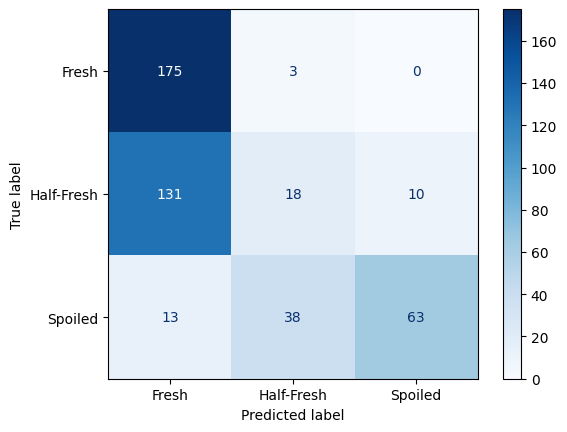

In [65]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = df_gpt['target']
y_pred = df_gpt['4o_prediction']
report = classification_report(y_true, y_pred, target_names=['Fresh', 'Half-Fresh', 'Spoiled'])
print(report)

cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Plot the confusion matrix for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fresh', 'Half-Fresh', 'Spoiled'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
def predict_single(name):
    image_path = f"Meat Freshness.v1-new-dataset.multiclass/valid/{name}"
    print(image_path)
    base64_image = encode_image(image_path)
    
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }
    
    payload = {
      "model": "gpt-4o",
        "messages": [
            {
                "role": "system",
                "content": "You are an expert health inspector responsible for identifying meat quality through pictures. Your job is to identify one of these choices and your response should only contain one of these choices: 'Spoiled', 'Half-Fresh', 'Fresh'. If you do not know, make an educated guess."
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ]
    }
    try:
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        response_content = response.json()['choices'][0]['message']['content']
        df_gpt.loc[index, "4o_prediction"]  = label_mapping[response_content]
        print(index, response_content)
    except:
        print('fail')

Meat Freshness.v1-new-dataset.multiclass/valid/FRESH-444-_JPG.rf.d96598f20df53cf495d27d93e6092ff2.jpg
450 Fresh


In [57]:
df_gpt.to_csv("chatgpt-4o.csv")

# ChatGPT 4 Prediction

In [6]:
df_gpt4 = df[['filename', 'target']].copy()
df_gpt4['4o_prediction'] = -1
df_gpt4

,filename,target,4o_prediction
0,HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd3...,1,-1
1,FRESH-91-_JPG.rf.5ce4d7d669bae2d26735e4edf0a17...,0,-1
2,FRESH-408-_JPG.rf.5ead7613098bae61f4a33fab1084...,0,-1
3,FRESH-344-_JPG.rf.5e8ec1875092af8f909b876ee314...,0,-1
4,HALF-FRESH-919-_JPG.rf.5f00a599bb9c9b7694db119...,1,-1
...,...,...,...
446,SPOILED-490-_JPG.rf.56a0be42dae8e67015a027f8da...,2,-1
447,SPOILED-189-_JPG.rf.557a72188a67f78d2335f67cef...,2,-1
448,FRESH-338-_JPG.rf.58b3eb5a892b4e2201209243b0df...,0,-1
449,SPOILED-26-_JPG.rf.59b69017d91e0af8f36accf2d71...,2,-1


In [7]:
for index, row in df_gpt4.iterrows():
    image_path = f"Meat Freshness.v1-new-dataset.multiclass/valid/{row['filename']}"
    print(image_path)
    base64_image = encode_image(image_path)
    
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }
    
    payload = {
      "model": "gpt-4-turbo",
        "messages": [
            {
                "role": "system",
                "content": "You are an expert health inspector responsible for identifying meat quality through pictures. Your job is to identify one of these choices and your response should only contain one of these choices: 'Spoiled', 'Half-Fresh', 'Fresh'. If you do not know, make an educated guess."
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ]
    }
    try:
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        response_content = response.json()['choices'][0]['message']['content']
        df_gpt4.loc[index, "4o_prediction"]  = label_mapping[response_content]
        print(index, response_content)
    except:
        print('fail')
print('done')

Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd330ff733.jpg
0 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/FRESH-91-_JPG.rf.5ce4d7d669bae2d26735e4edf0a1708f.jpg
1 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/FRESH-408-_JPG.rf.5ead7613098bae61f4a33fab108464e6.jpg
2 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/FRESH-344-_JPG.rf.5e8ec1875092af8f909b876ee314d536.jpg
3 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-919-_JPG.rf.5f00a599bb9c9b7694db119eefa7d96e.jpg
4 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-374-_JPG.rf.5ff7944f6e027a534af2bad036547f59.jpg
5 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/SPOILED-333-_JPG.rf.5fb3c53129b3d88d759f174b57848858.jpg
6 Spoiled
Meat Freshness.v1-new-dataset.multiclass/valid/SPOILED-353-_JPG.rf.5d4b9a9ad1386320d6e2dc46abdf47ab.jpg
7 Fresh
Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-980-_JPG.rf.5dcc7428c48f145f869c9c53197bf48a

In [21]:
df_gpt4.to_csv('gpt-4.csv')

              precision    recall  f1-score   support

       Fresh       0.47      0.99      0.63       178
  Half-Fresh       0.27      0.03      0.05       159
     Spoiled       0.81      0.41      0.55       114

    accuracy                           0.50       451
   macro avg       0.51      0.48      0.41       451
weighted avg       0.48      0.50      0.40       451

Confusion Matrix:
[[176   1   1]
 [145   4  10]
 [ 57  10  47]]


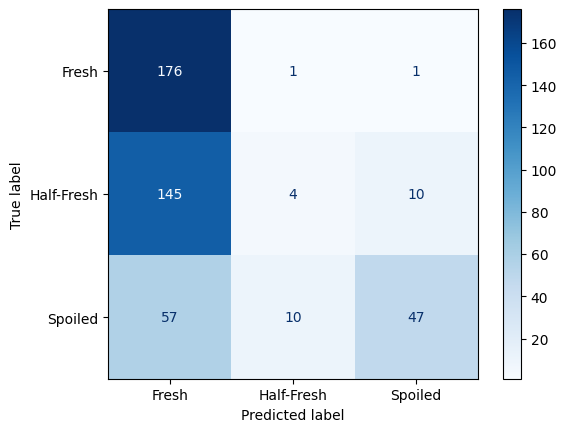

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = df_gpt4['target']
y_pred = df_gpt4['4o_prediction']
report = classification_report(y_true, y_pred, target_names=['Fresh', 'Half-Fresh', 'Spoiled'])
print(report)

cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Plot the confusion matrix for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fresh', 'Half-Fresh', 'Spoiled'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [30]:
df = pd.read_csv('Meat Freshness.v1-new-dataset.multiclass/train/_classes.csv')
df.columns = df.columns.str.strip()
df['target'] = df[['Fresh', 'Half-Fresh', 'Spoiled']].idxmax(axis=1)
label_mapping = {'Fresh': 0, 'Half-Fresh': 1, 'Spoiled': 2}
df['target'] = df['target'].map(label_mapping)
df = df[['filename', 'target']].copy()
df['target'].value_counts()

target
0    675
1    630
2    510
Name: count, dtype: int64